# Milestone 2

In [11]:
# imports 
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
from scripts import *

### I. Data Prepration

In [2]:
# Read the data
data_path = './data'  
images, labels = data_reader(data_path)

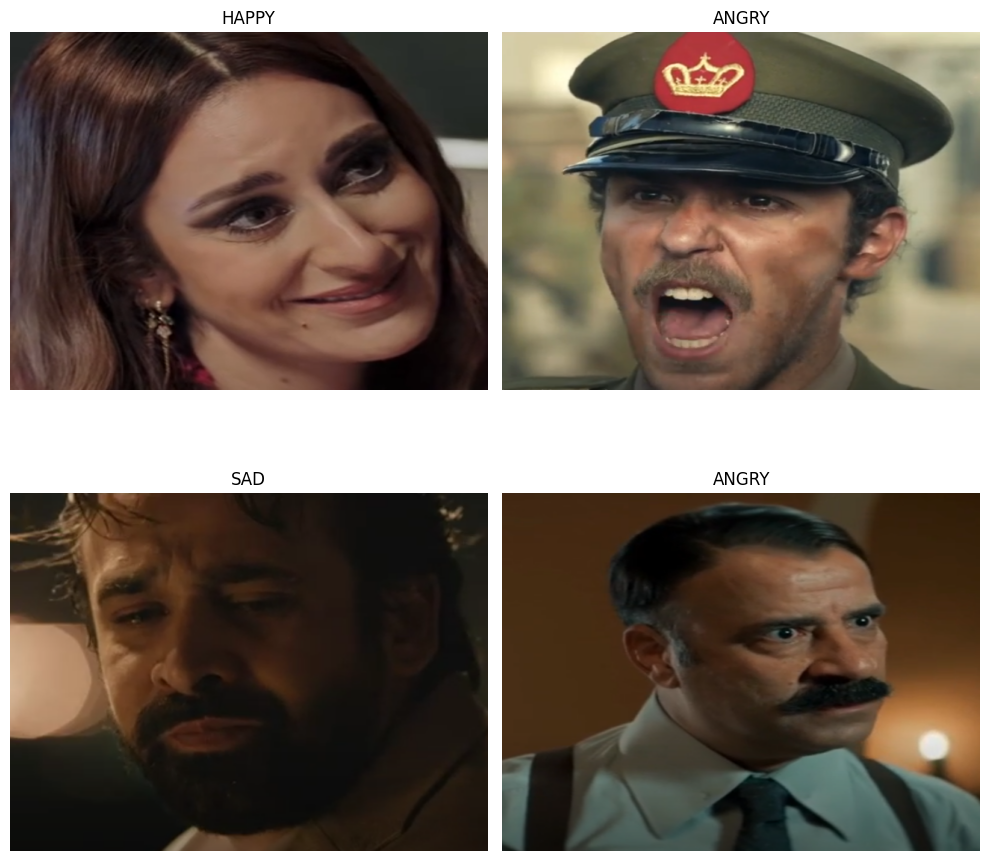

In [3]:
# View 4 random images and their titles
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(images))
    ax.imshow(images[idx])
    ax.set_title(labels[idx])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [4]:
# Preprocess the images 
train_tuple, val_tuple, test_tuple = data_preperator((images, labels))

train_data, train_labels = train_tuple
val_data, val_labels = val_tuple
test_data, test_labels = test_tuple

train_data.shape, train_labels.shape, val_data.shape, val_labels.shape, test_data.shape, test_labels.shape

((318, 512, 512, 3),
 (318,),
 (91, 512, 512, 3),
 (91,),
 (46, 512, 512, 3),
 (46,))

### II.First Model

In [5]:
# Predefined filters
import numpy as np

base_a = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

base_b = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
])

base_c = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

base_d = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
])

base_e = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
])

filter_a = np.stack([base_a]*3, axis=-1)
filter_b = np.stack([base_b]*3, axis=-1)
filter_c = np.stack([base_c]*3, axis=-1)
filter_d = np.stack([base_d]*3, axis=-1)
filter_e = np.stack([base_e]*3, axis=-1)


filters = [filter_a, filter_b, filter_c, filter_d, filter_e]

In [6]:
# Testing ConvLayer with Random filters
conv_layer = ConvLayer(4, (3, 3, 3))

output = conv_layer.forward(train_data[0])
output.shape

(510, 510, 4)

In [7]:
# Visualize the output of the convolutional layer
conv_layer = ConvLayer(5, (3, 3, 3), filter_weights=filters)

output = conv_layer.forward(train_data[0])
output.shape

(510, 510, 5)

In [9]:
# Testing the pooling layer
pooling_layer = PoolingLayer(pooling_type='MAX', pool_size=(2, 2))

output = pooling_layer.forward(train_data[0])
output.shape

(256, 256, 3)

### III. Second Model

In [12]:
# Test second_model is working
second_model = Second_Model()

example_image = torch.tensor(train_data[0], dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

output = second_model(example_image)

print("Output shape:", output.shape)
print("Output:", output)

Output shape: torch.Size([1, 4])
Output: tensor([[0.3806, 0.1973, 0.2071, 0.2150]], grad_fn=<SoftmaxBackward0>)


In [ ]:
# Training loop